#Image Caption Generation
Build an image caption generator model, as described in Vinyals, Oriol, et al. "Show and tell: A neural image caption generator." Proceedings of the IEEE conference on computer vision and pattern recognition. 2015.

In [0]:
from google.colab import drive
drive.mount('/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /drive


In [0]:
%cd /drive/My\ Drive/Deep\ Learing\ Course/deeplearning-2020/archive/canvas-2019/Practicals/Practical\ 5/5.2.\ Sequence-to-Sequence

/drive/My Drive/Deep Learing Course/deeplearning-2020/archive/canvas-2019/Practicals/Practical 5/5.2. Sequence-to-Sequence


In [0]:
import numpy as np
from tensorflow import keras
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, GRU, Embedding, TimeDistributed, Dense, RepeatVector, Add, Lambda,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

##Data preprocess

###Preprocess the descriptions


In [0]:
#how does the data looks like
filename = "data/Flickr8k_text/Flickr8k.token.txt"
# load descriptions
f=open(filename,"r")
for i,each in enumerate(f.readlines()):
	print(each)
	if i==5:
	 break
 

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .

1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .

1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .

1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .

1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .

1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting



In [0]:
#load descriptions to list
def load_descriptions(filename):
	mapping = dict()
	file = open(filename,'r')
	doc = file.read()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	file.close()
	return mapping

# parse descriptions
descriptions = load_descriptions(filename)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [0]:
print(list(descriptions.keys())[1])
print(list(descriptions.values())[1])

1001773457_577c3a7d70
['A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .']


- remove punctuation
- convert to lower case

In [0]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [0]:
list(descriptions.values())[1]

['black dog and spotted dog are fighting',
 'black dog and tricolored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other']

In [0]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'data/Flickr8k_text/descriptions.txt')

- Create vocabulary

In the video of this practice, there are codes here for creating vocabulary based on all descriptions. We move these codes to later cell and create the vocabulary based on all train descriptions.

### Preprocess Flickr_8k.trainImages.txt,Flickr_8k.devImages.txt,Flickr_8k.testImages.txt
- concatenate the path to  the image name: 2825540754_5e0c13e6b8.jpg------>data/Flicker8k_Dataset/2825540754_5e0c13e6b8.jpg

In [0]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	file = open(filename,'r')
	doc = file.read()
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = 'data/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print(list(train)[0])
print('Dataset: %d' % len(train))

3691729694_2b97f14c1e
Dataset: 6000


In [0]:
# load validation dataset (1K)
dev_fn = 'data/Flickr8k_text/Flickr_8k.devImages.txt'
dev = load_set(dev_fn)
print('Validation Dataset: %d' % len(dev))

Validation Dataset: 1000


In [0]:
# load test dataset (1K)
test_fn = 'data/Flickr8k_text/Flickr_8k.testImages.txt'
test = load_set(test_fn)
print('Test Dataset: %d' % len(test))

Test Dataset: 1000


In [0]:
# Below path contains all the images
images = 'data/Flicker8k_Dataset/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')
print(img[0])

data/Flicker8k_Dataset/2825540754_5e0c13e6b8.jpg


In [0]:
# Below file conatains the names of images to be used in train data
train_images_file = 'data/Flickr8k_text/Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))
# Create a list of all the training images with their full path names
train_img = []
for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images
print(train_img[0])

data/Flicker8k_Dataset/2825540754_5e0c13e6b8.jpg


In [0]:
# Below file conatains the names of images to be used in validation data
dev_images_file = 'data/Flickr8k_text/Flickr_8k.devImages.txt'
# Read the validation image names in a set# Read the test image names in a set
dev_images = set(open(dev_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
dev_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in dev_images: # Check if the image belongs to test set
        dev_img.append(i) # Add it to the list of test images

In [0]:
# Below file conatains the names of images to be used in test data
test_images_file = 'data/Flickr8k_text/Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

- load clean descriptions for traning set, develop set, test set

In [0]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	f=open(filename,'r')
	doc = f.read()
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions



In [0]:
# descriptions
train_descriptions = load_clean_descriptions('data/Flickr8k_text/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
print(train_descriptions.items())

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# descriptions
dev_descriptions = load_clean_descriptions('data/Flickr8k_text/descriptions.txt', dev)
print('Descriptions: validation=%d' % len(dev_descriptions))

Descriptions: validation=1000


In [0]:
# descriptions
test_descriptions = load_clean_descriptions('data/descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))

Descriptions: test=1000


- Create Vacabulary based on all train_descriptions

In [0]:
all_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_captions.append(cap)
len(all_captions)
# summarize vocabulary

# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))


preprocessed words 7578 -> 1651


In [0]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1
    
#vocab size
vocab_size = len(ixtoword) + 1 # one for padded 0's

def max_length(lines):	
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(all_captions)
print('Description Length: %d' % max_length)

Description Length: 34


## Transfer learning from inception model who had been trained on ImageNet---preprocess images
- Get features for each image based on inception model  who had been trained on ImageNet

In [0]:
import _pickle as cPickle

- to preprocess image: resize to (299,299), normalize to [-1,1]  

In [0]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [0]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

96116736/96112376 [==============================] - 7s 0us/step


In [0]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

- Function to encode a given image into a vector of size (2048, )

In [0]:
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

- For images in training set

In [0]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

# Save the bottleneck train features to disk
with open("data/encoded_train_images.pkl", "wb") as encoded_pickle:
    cPickle.dump(encoding_train, encoded_pickle)

- For images in develop set

In [0]:

start = time()
encoding_dev = {}
for img in dev_img:
    encoding_dev[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)
# Save the bottleneck train features to disk
with open("data/encoded_dev_images.pkl", "wb") as encoded_pickle:
    cPickle.dump(encoding_dev, encoded_pickle)


- For images in test set

In [0]:

# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

# Save the bottleneck test features to disk
with open("data/encoded_test_images.pkl", "wb") as encoded_pickle:
    cPickle.dump(encoding_test, encoded_pickle)


In [0]:
train_features = load(open("data/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [0]:
dev_features = load(open("data/encoded_dev_images.pkl", "rb"))
print('Photos: dev=%d' % len(dev_features))

Photos: dev=1000


In [0]:
test_features = load(open("data/encoded_test_images.pkl", "rb"))
print('Photos: test=%d' % len(test_features))

Photos: test=1000


#Build sentence generator model

- load pretrained word Embedding weights

In [0]:
# Load Glove vectors
glove_dir = 'data/Flickr8k_text/'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.300d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


- get the word embedding weights for our vocabulary

In [0]:

embedding_dim = 300
# Get 300-dim dense vector for each of  in  vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [0]:
from keras.preprocessing import sequence
from keras.utils.np_utils import to_categorical

### Model architecture

In [0]:
# image input
image_in = Input(shape=(2048,), name='image_inputs') # feature from inception net has dimension (, 2048)
fe1 = Dropout(0.5, name='dropout_img_feats')(image_in)
fe2 = Dense(300, activation='relu', name = 'dense_img_feats')(fe1) # reduce the dimension into 300 with FC projection

# caption input
cap_in = Input(shape=(None,),name='caption_inputs') # as input for RNN, with dimension (, None) ; we set it into None since we will re-use the model it in inference stage (need a variable lengh of inputs)

#computation graph
embed_cap = Embedding(vocab_size, embedding_dim, weights = [embedding_matrix], trainable = False) # with dimension (, None, embedding_dim)
se1 = embed_cap(cap_in)
drop_cap = Dropout(0.5)
se2 = drop_cap(se1)
lstm_layer = LSTM(300)
se3 = lstm_layer(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(300, activation='relu')
dense_decoder = decoder2(decoder1)
pred_layer = Dense(vocab_size, activation='softmax')
outputs = pred_layer(dense_decoder)

model = Model(inputs=[image_in, cap_in], outputs=outputs)

In [0]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
caption_inputs (InputLayer)     (None, None)         0                                            
__________________________________________________________________________________________________
image_inputs (InputLayer)       (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 300)    495600      caption_inputs[0][0]             
__________________________________________________________________________________________________
dropout_img_feats (Dropout)     (None, 2048)         0           image_inputs[0][0]               
____________________________________________________________________________________________

### Training process

In [0]:
adam = optimizers.Adam(lr=0.001)

In [0]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)

In [0]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
  
    X1, X2, y = list(), list(), list()
    n=0
    
    words=list(wordtoix.keys())
    while 1:
        # loop for ever over images
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence,ignore word not in vocab
                seq = [wordtoix[word] for word in desc.split(' ') if word in words]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode it as one-hot vector
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [0]:
epochs = 20
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

In [0]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 264s 132ms/step - loss: 4.0090 - accuracy: 0.2508
Epoch 1/1
2000/2000 [==============================] - 264s 132ms/step - loss: 3.3312 - accuracy: 0.3025
Epoch 1/1
2000/2000 [==============================] - 264s 132ms/step - loss: 3.1233 - accuracy: 0.3214
Epoch 1/1
2000/2000 [==============================] - 264s 132ms/step - loss: 2.9907 - accuracy: 0.3327
Epoch 1/1
2000/2000 [==============================] - 261s 131ms/step - loss: 2.8921 - accuracy: 0.3414
Epoch 1/1
2000/2000 [==============================] - 262s 131ms/step - loss: 2.8134 - accuracy: 0.3485
Epoch 1/1
2000/2000 [==============================] - 262s 131ms/step - loss: 2.7477 - accuracy: 0.3553
Epoch 1/1
2000/2000 [==============================] - 263s 131ms/step - loss: 2.6950 - accuracy: 0.3608
Epoch 1/1
2000/2000 [==============================] - 261s 131ms/step - loss: 2.6473 - accuracy: 0.3657
Epoch 1/1
2000/2000 [==============================] - 

In [0]:
#model.load_weights('./model_9.h5')

###Inference process

In [0]:
###to generate sentence word by word using sentence generator model. e.g. the prediction for the first word. input:[images feutres, "startseq"] ####
###the prediction for the second word. Input[image features, "startseq"+the first predicted word].... the prediction will be stoped until the predicted word  ####
### is the "endseq" or the number of predicted words reaches the max_length-----------------------------------------------------------------------------------####

def greedySearch(photo):
    in_text = 'startseq'
    words=list(wordtoix.keys())
    for i in range(max_length):
      #--YOUR CODE---#

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

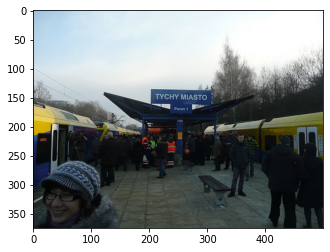

Greedy: man in black shirt is walking away from crowd of people


In [0]:
pic = list(test_features.keys())[4]
image = test_features[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

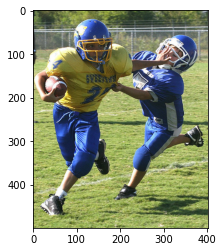

Greedy: two football players are fighting over the ball


In [0]:
pic = list(test_features.keys())[30]
image = test_features[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))